In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix
import scipy

## Read and take a quick look at the data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train, y_train = train_df.iloc[:, 1:].to_numpy(), train_df.iloc[:, 0].to_numpy()
X_test = test_df.to_numpy()

In [5]:
X_train.shape

(42000, 784)

(-0.5, 27.5, 27.5, -0.5)

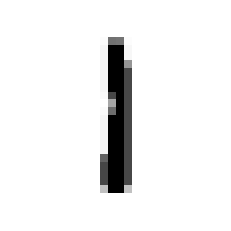

In [6]:
some_digit = X_train[2].reshape(28, 28)
plt.imshow(some_digit, cmap=mpl.cm.binary)
plt.axis('off')

In [7]:
y_train[2]

1

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

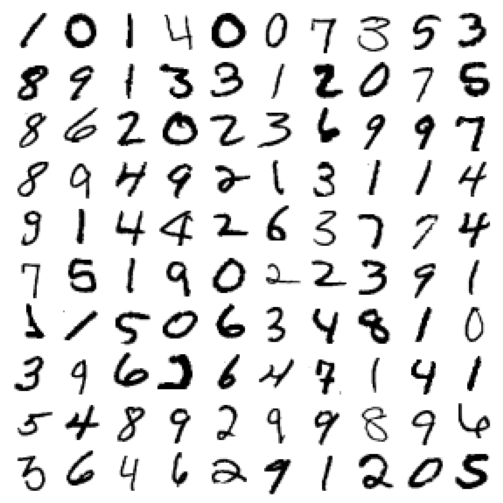

In [9]:
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

## Data augmentation

In [10]:
shifted_digit = scipy.ndimage.shift(some_digit, [10, 2], cval=0) # shift image 10 pixels down and 2 pixels right

(-0.5, 27.5, 27.5, -0.5)

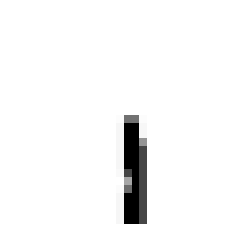

In [11]:
plt.imshow(shifted_digit, cmap=mpl.cm.binary)
plt.axis('off')

In [12]:
shift_directions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
X_train_augmented = []
y_train_augmented = []
for image, label in zip(X_train, y_train):
    for x, y in shift_directions:
        X_train_augmented.append(scipy.ndimage.shift(image.reshape(28,28), [x, y], cval=0).reshape(-1))
        y_train_augmented.append(label)
    

In [13]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [14]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [15]:
X_train_augmented.shape

(168000, 784)

## Train a model

### KNN

In [16]:
knn_clf = KNeighborsClassifier()

In [17]:
param_grid = [
    {'weights': ['uniform', 'distance'],
     'n_neighbors': [2, 3, 4, 5]},
]

In [18]:
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)

In [19]:
grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.964 total time=  50.8s
[CV 2/5] END ....n_neighbors=2, weights=uniform;, score=0.966 total time=  51.0s
[CV 3/5] END ....n_neighbors=2, weights=uniform;, score=0.965 total time=  49.0s
[CV 4/5] END ....n_neighbors=2, weights=uniform;, score=0.965 total time=  49.5s
[CV 5/5] END ....n_neighbors=2, weights=uniform;, score=0.965 total time=  48.6s
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.973 total time=  48.3s
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.974 total time=  48.0s
[CV 3/5] END ...n_neighbors=2, weights=distance;, score=0.973 total time=  48.2s
[CV 4/5] END ...n_neighbors=2, weights=distance;, score=0.973 total time=  48.4s
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.973 total time=  48.4s
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  52.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [20]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [21]:
final_model = grid_search.best_estimator_

In [22]:
y_train_pred = cross_val_predict(final_model, X_train_augmented, y_train_augmented, cv=3)

In [23]:
y_train_pred

array([8, 7, 0, ..., 6, 9, 8])

Confusion matrix

In [24]:
conf_mx = confusion_matrix(y_train_augmented, y_train_pred)

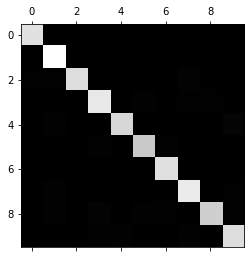

In [25]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [26]:
final_predictions = final_model.predict(X_test)

## Save the predictions

In [27]:
# Save submission
with open('submission.csv', 'w') as wf:
    wf.write('ImageId,Label\n')
    for i, y in enumerate(final_predictions):
        wf.write(f'{i+1},{y}\n')